In [1]:
# Load the dataset
#print("Initial Dataset Info:")
#data = pd.read_csv("email.csv")  # Replace with your file path
#print(data.info())  # Basic dataset info
#print("\nUnique Categories:", data['Category'].unique())

In [2]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

# Read the CSV file without header
import io
data = pd.read_csv(io.BytesIO(uploaded['all_tickets_processed_improved_v3.csv']), sep=',')
columns = ['Document', 'Topic_group']
# Display basic information about the dataset
print("Shape of the dataset:", data.shape)
print(data.head())




Saving all_tickets_processed_improved_v3.csv to all_tickets_processed_improved_v3.csv
Shape of the dataset: (47837, 2)
                                            Document    Topic_group
0  connection with icon icon dear please setup ic...       Hardware
1  work experience user work experience user hi w...         Access
2  requesting for meeting requesting meeting hi p...       Hardware
3  reset passwords for external accounts re expir...         Access
4  mail verification warning hi has got attached ...  Miscellaneous


In [3]:
# Check for missing values
missing_values = data['Topic_group'].isnull().sum()
print(f"Missing values in 'Topic_group': {missing_values}")

Missing values in 'Topic_group': 0


In [4]:
print("Initial Dataset Info:")
print(data.info())  # Basic dataset info
print("\nUnique Categories:", data['Topic_group'].unique())


Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     47837 non-null  object
 1   Topic_group  47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB
None

Unique Categories: ['Hardware' 'Access' 'Miscellaneous' 'HR Support' 'Purchase'
 'Administrative rights' 'Storage' 'Internal Project']


In [5]:
data = data[data['Topic_group'].isin(['Hardware', 'Access', 'Miscellaneous', 'HR Support', 'Purchase', 'Administrative rights', 'Storage', 'Internal Project'])]
print(data['Topic_group'].value_counts())




Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, dtype: int64


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


<ipython-input-7-690f1df63994>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Topic_group', data=data, ax=axs[0], palette='viridis')


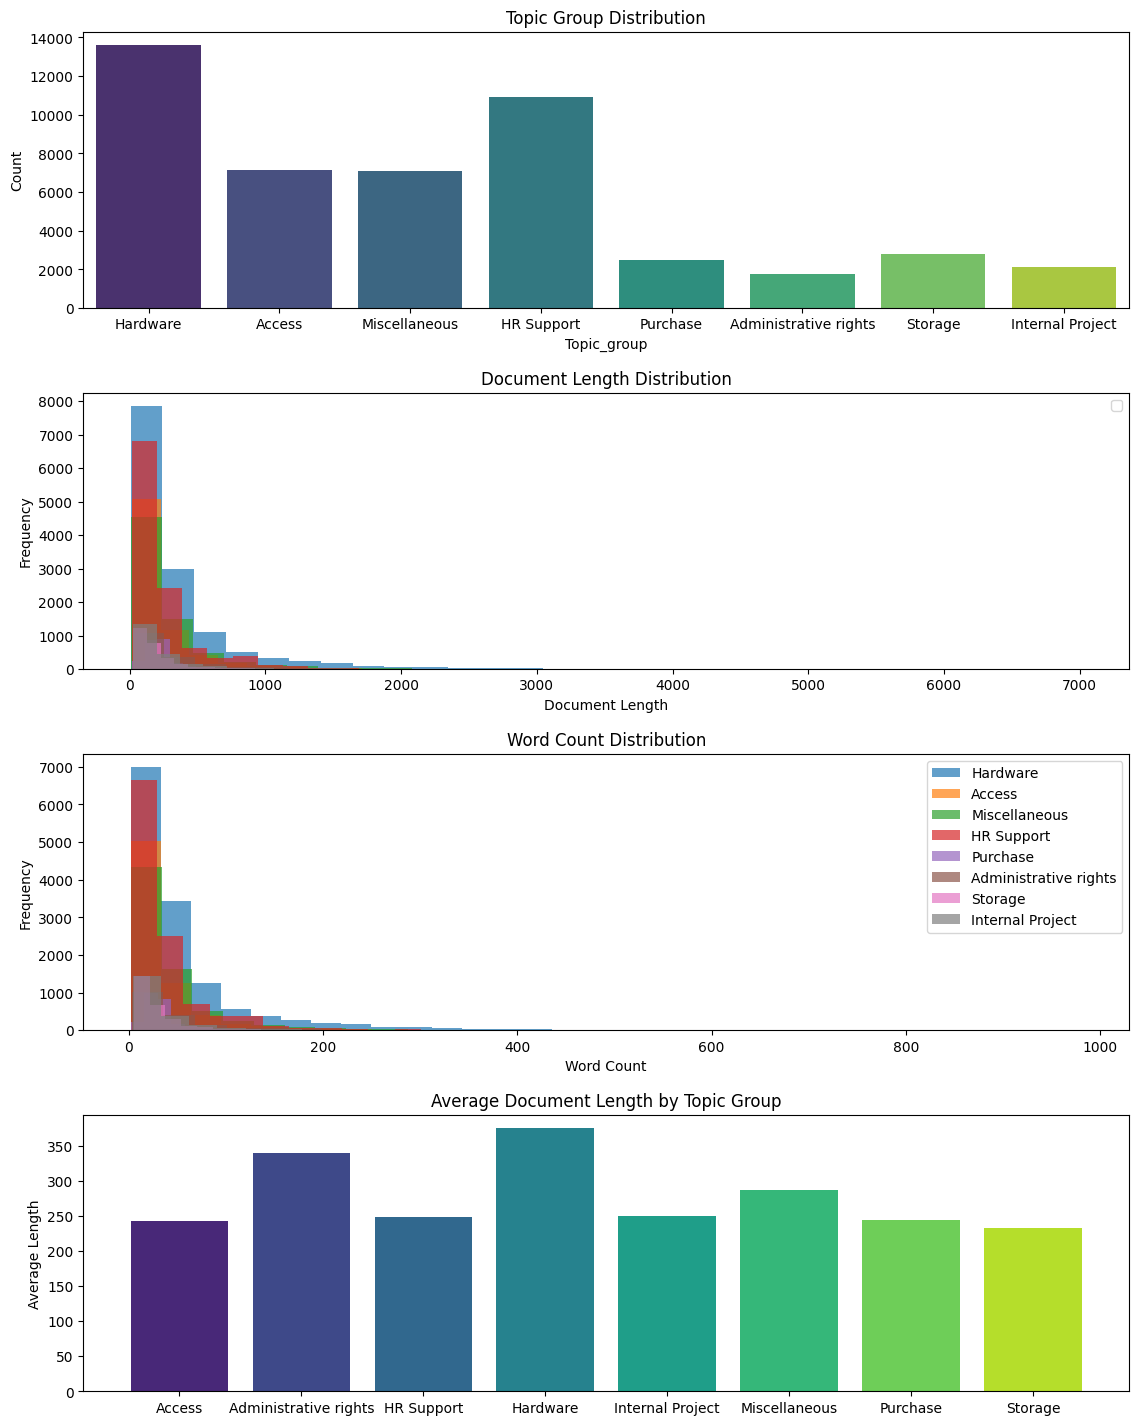

In [7]:
# Calculate metrics
data['Document_Length'] = data['Document'].apply(len)  # Calculate document length
data['Word_Count'] = data['Document'].apply(lambda x: len(x.split()))  # Count words in each document

# Split data by Topic_group for analysis
topic_groups = data['Topic_group'].unique()
data_by_topic = {group: data[data['Topic_group'] == group] for group in topic_groups}

# Set up subplots
fig, axs = plt.subplots(4, figsize=(12, 15))
fig.tight_layout(pad=4.0)

# 1. Topic group distribution
sns.countplot(x='Topic_group', data=data, ax=axs[0], palette='viridis')
axs[0].set_title('Topic Group Distribution')
axs[0].set_ylabel('Count')

# 2. Document length distribution for each Topic Group
for group in topic_groups:
    axs[1].hist(data_by_topic[group]['Document_Length'], bins=30, alpha=0.7)
axs[1].set_title('Document Length Distribution')
axs[1].set_xlabel('Document Length')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# 3. Word count distribution for each Topic Group
for group in topic_groups:
    axs[2].hist(data_by_topic[group]['Word_Count'], bins=30, alpha=0.7, label=group)
axs[2].set_title('Word Count Distribution')
axs[2].set_xlabel('Word Count')
axs[2].set_ylabel('Frequency')
axs[2].legend()

# 4. Average document length for each Topic Group
avg_length = data.groupby('Topic_group')['Document_Length'].mean()
axs[3].bar(avg_length.index, avg_length.values, color=sns.color_palette('viridis', len(topic_groups)))
axs[3].set_title('Average Document Length by Topic Group')
axs[3].set_ylabel('Average Length')

plt.show()

<ipython-input-8-2e6b240f5241>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Topic_group', y='Document_Length', data=data, ax=axs[0], palette='viridis')
<ipython-input-8-2e6b240f5241>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Topic_group', y='Word_Count', data=data, ax=axs[1], palette='viridis')


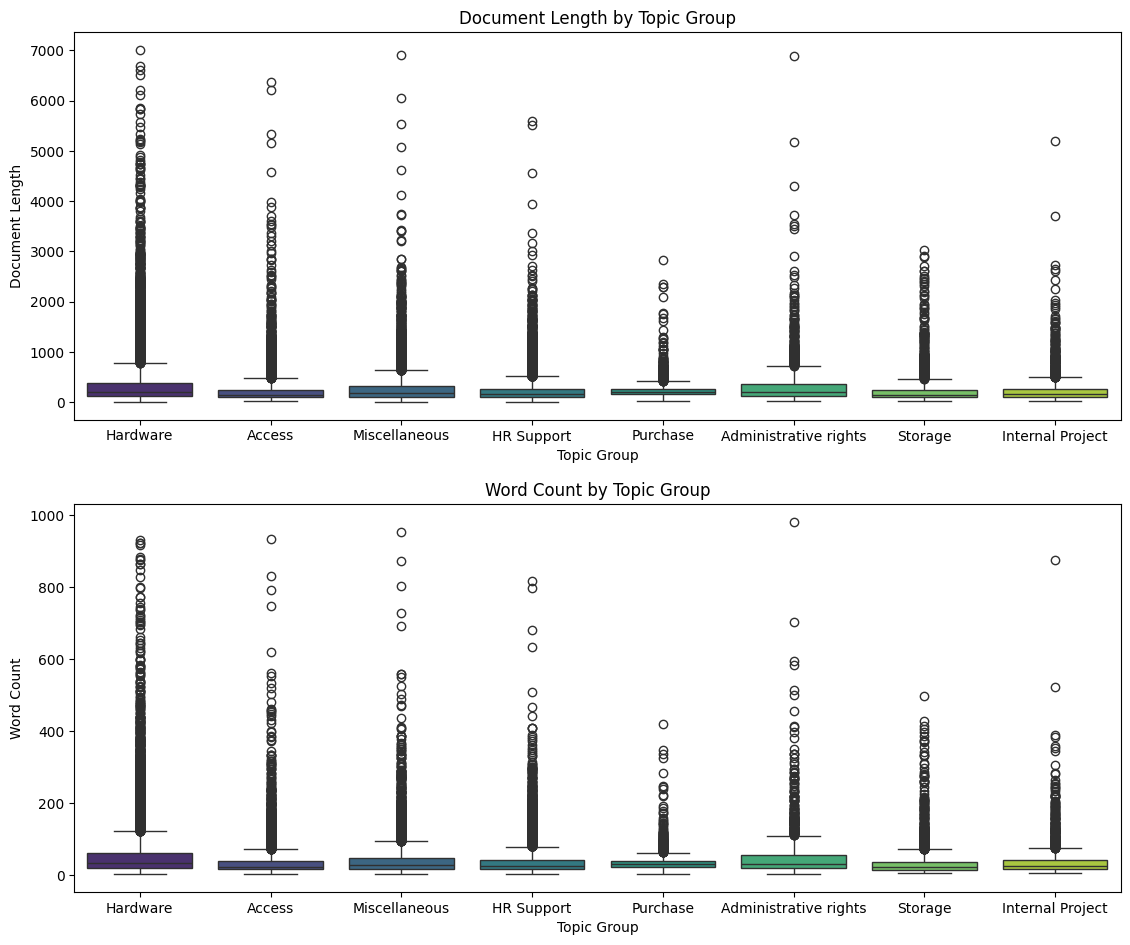

In [8]:
# Set up subplots
fig, axs = plt.subplots(2, figsize=(12, 10))
fig.tight_layout(pad=4.0)

# 1. Boxplot of Document Length by Topic Group
sns.boxplot(x='Topic_group', y='Document_Length', data=data, ax=axs[0], palette='viridis')
axs[0].set_title('Document Length by Topic Group')
axs[0].set_xlabel('Topic Group')
axs[0].set_ylabel('Document Length')

# 2. Boxplot of Word Count by Topic Group
sns.boxplot(x='Topic_group', y='Word_Count', data=data, ax=axs[1], palette='viridis')
axs[1].set_title('Word Count by Topic Group')
axs[1].set_xlabel('Topic Group')
axs[1].set_ylabel('Word Count')

plt.show()

In [9]:
# Encode the Target Variable (Topic_group)
print("\nEncoding target labels...")
label_encoder = LabelEncoder()
data['Topic_group'] = label_encoder.fit_transform(data['Topic_group'])  # Encoding categorical labels
print("\nEncoded Categories:\n", data['Topic_group'].value_counts())


Encoding target labels...

Encoded Categories:
 Topic_group
3    13617
2    10915
0     7125
5     7060
7     2777
6     2464
4     2119
1     1760
Name: count, dtype: int64


In [10]:
# Clean the text data
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.strip()  # Trim leading/trailing spaces
    return text

print("\nCleaning text data...")
data['Document'] = data['Document'].apply(clean_text)


Cleaning text data...


In [11]:
# Tokenize and Pad Sequences
print("\nTokenizing and padding sequences...")
tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary to top 5000 words
tokenizer.fit_on_texts(data['Document'])  # Learn the vocabulary from the data
sequences = tokenizer.texts_to_sequences(data['Document'])  # Convert text to sequences

# Pad sequences to a fixed length
X_tokenized = pad_sequences(sequences, maxlen=100)


Tokenizing and padding sequences...


In [12]:
# Prepare data for the model
X = X_tokenized  # Tokenized sequences
y = data['Topic_group']  # Encoded labels

# Step 6: Train-Test Split
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the train/test sets
print("\nShapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Splitting data into training and testing sets...

Shapes:
X_train: (38269, 100) y_train: (38269,)
X_test: (9568, 100) y_test: (9568,)


In [13]:
# Define RNN model
def build_rnn():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))  # Word embeddings
    model.add(SimpleRNN(32, return_sequences=False))  # RNN layer
    model.add(Dense(len(data['Topic_group'].unique()), activation='softmax'))  # Output layer
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [15]:
# Train RNN model
print("Training RNN model...")
start_time_rnn = time.time()
rnn_model = build_rnn()
history_rnn = rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)
end_time_rnn = time.time()
rnn_execution_time = end_time_rnn - start_time_rnn

Training RNN model...
Epoch 1/10
957/957 - 31s - 33ms/step - accuracy: 0.5586 - loss: 1.2964 - val_accuracy: 0.7221 - val_loss: 0.9102
Epoch 2/10
957/957 - 38s - 40ms/step - accuracy: 0.7460 - loss: 0.8265 - val_accuracy: 0.6640 - val_loss: 1.0530
Epoch 3/10
957/957 - 41s - 43ms/step - accuracy: 0.7885 - loss: 0.6778 - val_accuracy: 0.7446 - val_loss: 0.8469
Epoch 4/10
957/957 - 27s - 28ms/step - accuracy: 0.8056 - loss: 0.6332 - val_accuracy: 0.7336 - val_loss: 0.9261
Epoch 5/10
957/957 - 41s - 43ms/step - accuracy: 0.8087 - loss: 0.6187 - val_accuracy: 0.7740 - val_loss: 0.7510
Epoch 6/10
957/957 - 41s - 43ms/step - accuracy: 0.8002 - loss: 0.6015 - val_accuracy: 0.6331 - val_loss: 1.0148
Epoch 7/10
957/957 - 41s - 43ms/step - accuracy: 0.7692 - loss: 0.6831 - val_accuracy: 0.7248 - val_loss: 0.8688
Epoch 8/10
957/957 - 41s - 42ms/step - accuracy: 0.8428 - loss: 0.4945 - val_accuracy: 0.7263 - val_loss: 0.8798
Epoch 9/10
957/957 - 27s - 28ms/step - accuracy: 0.8856 - loss: 0.3700 - v

In [16]:
# Evaluate the RNN model
print("\nEvaluate")
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print(f"RNN Model Accuracy: {rnn_accuracy}")


Evaluate
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7359 - loss: 0.9232
RNN Model Accuracy: 0.7366220951080322


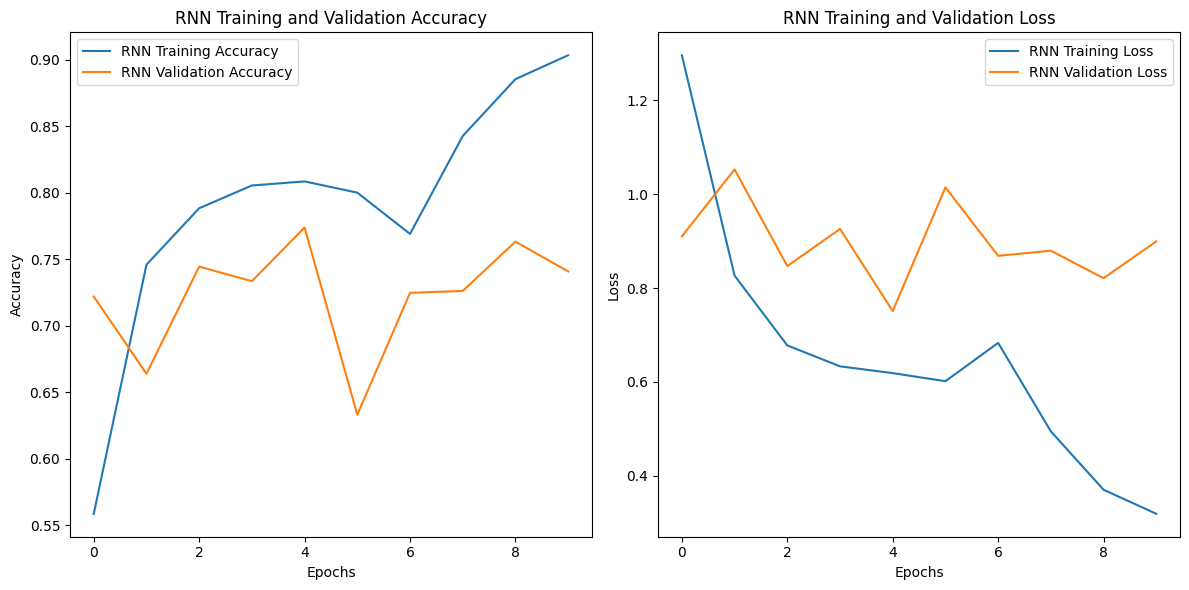

In [17]:
# RNN Training History
plt.figure(figsize=(12, 6))

# Plot RNN Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='RNN Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Validation Accuracy')
plt.title('RNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot RNN Loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='RNN Training Loss')
plt.plot(history_rnn.history['val_loss'], label='RNN Validation Loss')
plt.title('RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Define LSTM model
def build_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))  # Word embeddings
    model.add(LSTM(32, return_sequences=False))  # LSTM layer
    model.add(Dense(len(data['Topic_group'].unique()), activation='softmax'))  # Output layer
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [21]:
# Train LSTM model
print("Training LSTM model...")
start_time_lstm = time.time()
lstm_model = build_lstm()
history_lstm = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)
end_time_lstm = time.time()
lstm_execution_time = end_time_lstm - start_time_lstm

Training LSTM model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


957/957 - 48s - 50ms/step - accuracy: 0.6642 - loss: 0.9977 - val_accuracy: 0.7936 - val_loss: 0.6595
Epoch 2/10
957/957 - 83s - 87ms/step - accuracy: 0.8468 - loss: 0.5009 - val_accuracy: 0.8390 - val_loss: 0.5122
Epoch 3/10
957/957 - 82s - 86ms/step - accuracy: 0.8843 - loss: 0.3694 - val_accuracy: 0.8407 - val_loss: 0.4954
Epoch 4/10
957/957 - 81s - 85ms/step - accuracy: 0.9017 - loss: 0.3134 - val_accuracy: 0.8432 - val_loss: 0.5071
Epoch 5/10
957/957 - 81s - 85ms/step - accuracy: 0.9176 - loss: 0.2663 - val_accuracy: 0.8440 - val_loss: 0.5478
Epoch 6/10
957/957 - 82s - 85ms/step - accuracy: 0.9272 - loss: 0.2326 - val_accuracy: 0.8362 - val_loss: 0.5699
Epoch 7/10
957/957 - 47s - 49ms/step - accuracy: 0.9381 - loss: 0.2001 - val_accuracy: 0.8409 - val_loss: 0.5735
Epoch 8/10
957/957 - 85s - 88ms/step - accuracy: 0.9411 - loss: 0.1865 - val_accuracy: 0.8333 - val_loss: 0.6045
Epoch 9/10
957/957 - 78s - 81ms/step - accuracy: 0.9471 - loss: 0.1681 - val_accuracy: 0.8337 - val_loss: 0

In [22]:
# Evaluate the LSTM model
print("\nEvaluating LSTM model...")
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {lstm_accuracy}")


Evaluating LSTM model...
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8366 - loss: 0.6480
LSTM Model Accuracy: 0.8313127160072327


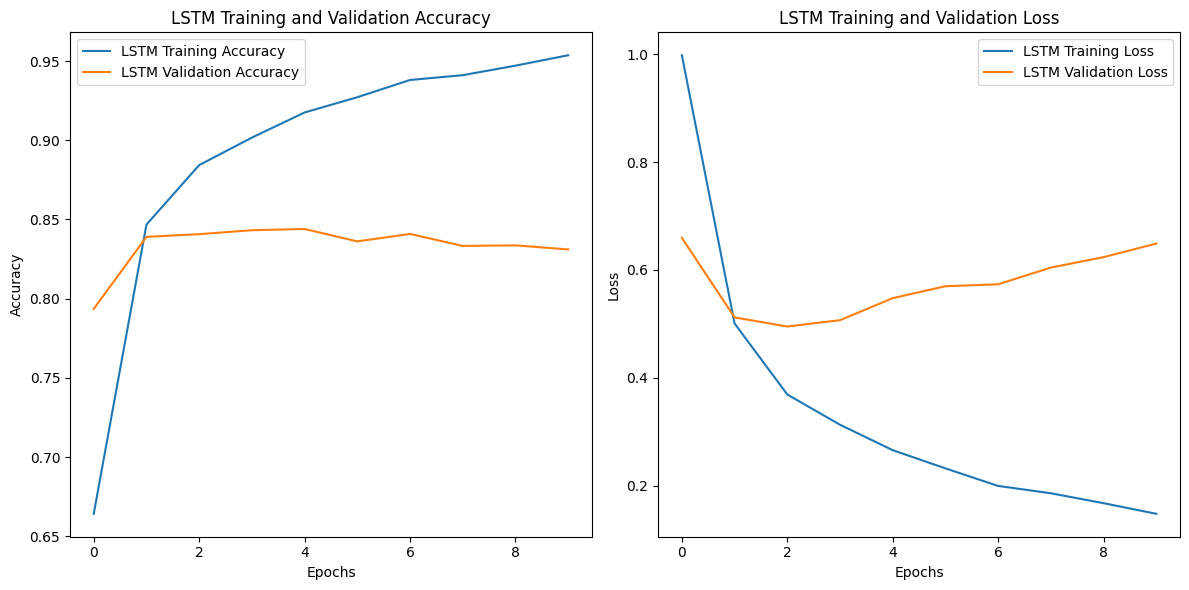

In [23]:
# LSTM Training History
plt.figure(figsize=(12, 6))

# Plot LSTM Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot LSTM Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-24-941d122e83c4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Test Accuracy", data=metrics_df, ax=axs[0], palette="viridis")
<ipython-input-24-941d122e83c4>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Training Accuracy", data=metrics_df, ax=axs[1], palette="viridis")
<ipython-input-24-941d122e83c4>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Execution Time (s)", data=metrics_df, ax=axs[2], palette="viridis")


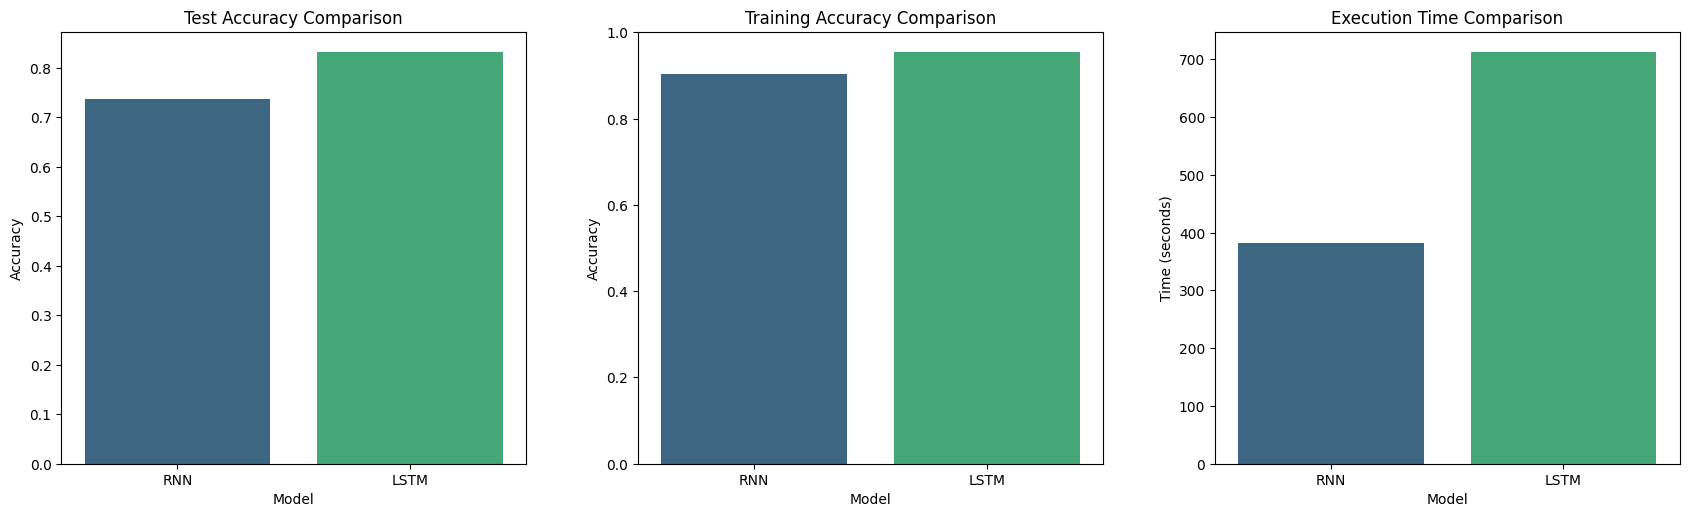

In [24]:

# Collect Metrics
metrics = {
    "Model": ["RNN", "LSTM"],
    "Test Accuracy": [rnn_accuracy, lstm_accuracy],
    "Training Accuracy": [history_rnn.history['accuracy'][-1], history_lstm.history['accuracy'][-1]],
    "Execution Time (s)": [rnn_execution_time, lstm_execution_time]
}

# Create DataFrame for Visualization
metrics_df = pd.DataFrame(metrics)

# Plot Comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.tight_layout(pad=5.0)

# Test Accuracy Comparison
sns.barplot(x="Model", y="Test Accuracy", data=metrics_df, ax=axs[0], palette="viridis")
axs[0].set_title("Test Accuracy Comparison")
axs[0].set_ylabel("Accuracy")

# Training Accuracy Comparison
sns.barplot(x="Model", y="Training Accuracy", data=metrics_df, ax=axs[1], palette="viridis")
axs[1].set_title("Training Accuracy Comparison")
axs[1].set_ylabel("Accuracy")

# Execution Time Comparison
sns.barplot(x="Model", y="Execution Time (s)", data=metrics_df, ax=axs[2], palette="viridis")
axs[2].set_title("Execution Time Comparison")
axs[2].set_ylabel("Time (seconds)")

plt.show()